In [211]:
import localgraphclustering as lgc

import time
import numpy as np

# Import the graph_tool module for visualization.
from graph_tool.all import * 

# Import matplotlib 
import matplotlib.pyplot as plt

# Just a useful function.
def diff(a, b):
        b = set(b)
        return np.asarray([aa for aa in a if aa not in b], dtype = 'int64')
    
import pickle
import csv

In [212]:
# Read graph. This also supports gml and graphml format.
g = lgc.GraphLocal('./datasets/senate.graphml','graphml')

/usr/local/lib/python3.6/site-packages/localgraphclustering/GraphLocal.py:174: UserWarning: Loading a graphml is not efficient, we suggest using an edgelist format for this API.
  warnings.warn("Loading a graphml is not efficient, we suggest using an edgelist format for this API.")


In [227]:
# Add data to graphtool.
g_gtool = load_graph("./datasets/senate.graphml")
    
remove_self_loops(g_gtool)

# Compute a layout for the graph.
#pos = sfdp_layout(g_gtool, gamma=10.0, mu=10.0, mu_p=10.0, verbose = False)  

coordinates = pickle.load( open( "./datasets/senate_pos.p", "rb" ) )

temp = []
pos = g_gtool.new_vertex_property("vector<double>")
for i in range(g._num_vertices):
    pos[i] = coordinates[g_gtool.vertex(i)]
    temp.append(list(reversed(np.dot(coordinates[g_gtool.vertex(i)],-1))))

rows = []

with open('./datasets/senate-unrolled.years') as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    for row in csvReader:
        rows.append(row)
        
node_colours = g_gtool.new_vertex_property("double")
node_text = g_gtool.new_vertex_property("string")
node_order = g_gtool.new_vertex_property("int")
#temp2 = np.argsort(temp, axis=0)
#step = 7
  
#ll = {}
#for i in range(1789,2008,1): 
#    ll[i] = []
#    
#for i in range(g._num_vertices):
#    idx = int(temp2[i][0])
#    year = 1789 + 2*int(rows[idx][0]) - 2
#    ll[year].append(idx)
#    node_colours[i] = 1789 + 2*int(rows[i][0]) - 2
#    node_text[i] = ""
#    node_order[i] = 0
#  
#i = 1789
#while i <= 2007:
#    
#    idx = ll[i][0]
#    node_text[idx] = str(i)
#    node_order[idx] = i
#    
#    i = i + 2*step
  
#idx = ll[2007][0]

years = []

for i in range(g._num_vertices):
    years.append(1789 + 2*int(rows[i][0]) - 2)
    node_colours[i] = 1789 + 2*int(rows[i][0]) - 2

ll = [51, 262, 237, 590, 985, 1038, 1304, 1337, 1779, 2088, 2494, 2878, 3669, 4008, 4391, 5002, 5643, 6394, 6719, 7767, 8289, 8893]

for i in ll:
    node_text[i] = years[i]
    node_order[i] = str(i)
    
print("Done!")

Done!


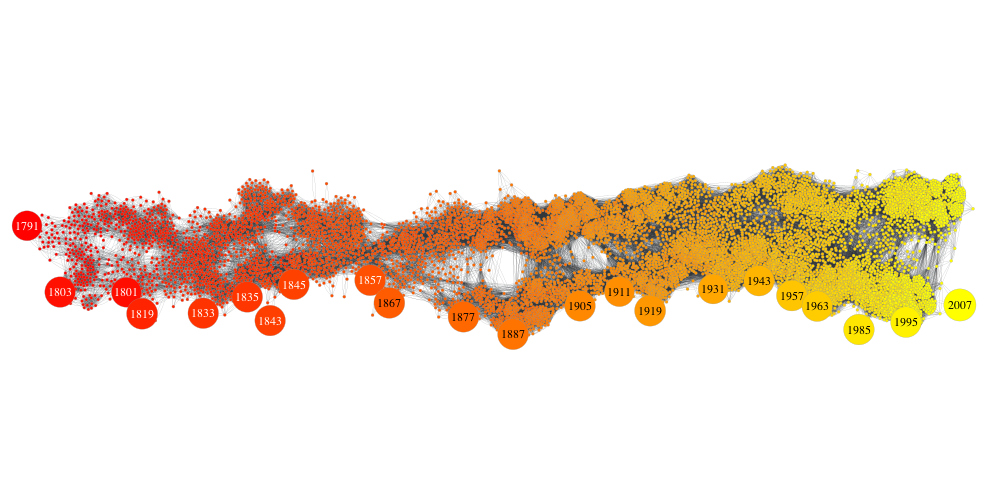

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x144ca6e10, at 0x13539f0f0>

In [231]:
# Plot solutions for global eigenvector

c_map = plt.get_cmap('autumn')

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=3,
           vertex_fill_color=node_colours, 
           vorder=node_order,
           vertex_text=node_text,
           edge_pen_width=0.1,
           vcmap=c_map
           #output='./tmp/senate.png')
          )

# For exaplanation of the senate data please refer to
# K. Fountoulakis, D. Gleich and M. Mahoney, An optimization approach to locally-biased graph algorithms,
# Proceedings of the IEEE 105 (2), 256-272.

In [5]:
ncp_instance = lgc.NCPData(g)
ncp_instance.approxPageRank(ratio=0.5,timeout=7200)

There are  1  connected components in the graph


<class 'localgraphclustering.ncp.NCPData'>


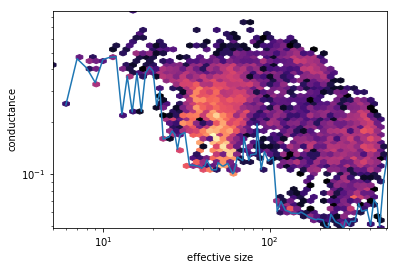

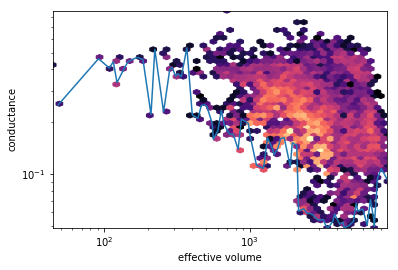

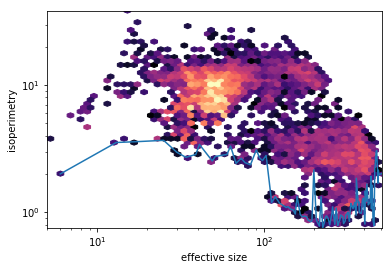

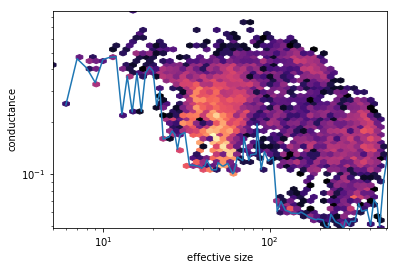

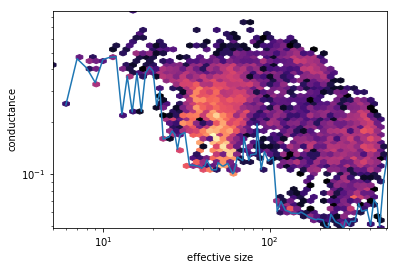

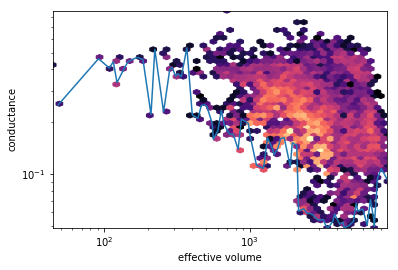

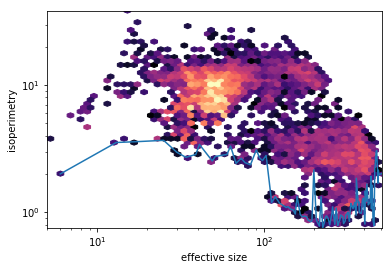

In [8]:
ncp_plots = lgc.NCPPlots(ncp_instance,method_name = "acl")
#plot conductance vs size
fig, ax = ncp_plots.cond_by_size()
plt.show()
#plot conductance vs volume
fig, ax = ncp_plots.cond_by_vol()
plt.show()
#plot isoperimetry vs size
fig, ax = ncp_plots.isop_by_size()
plt.show()

In [233]:
# Read John Hopkins graph.
g = lgc.GraphLocal('./datasets/JohnsHopkins.graphml','graphml')

/usr/local/lib/python3.6/site-packages/localgraphclustering/GraphLocal.py:174: UserWarning: Loading a graphml is not efficient, we suggest using an edgelist format for this API.
  warnings.warn("Loading a graphml is not efficient, we suggest using an edgelist format for this API.")


In [241]:
## Add data to graphtool.
g_gtool = load_graph("./datasets/JohnsHopkins.graphml")
    
remove_self_loops(g_gtool)

g_v_prop = g_gtool.vertex_properties
feature_list = [g_v_prop.dorm,g_v_prop.majorIndex,g_v_prop.year]

number_feature = 0

ref_nodes = []
info_ref_nodes = []

for kk in feature_list:
    
    feature = kk

    for ff in list(set(feature.a)):
        
        if ff == 0:
            continue

        feature_array = np.zeros(g_gtool.num_vertices())
        feature_ff_nodes = []
        for i in range(g_gtool.num_vertices()):
            feature_array[i] = feature[i]
            if feature_array[i] == ff:
                feature_ff_nodes.append(i)

        g_ff = g_gtool.copy()

        del_list_ff = list(set(range(g_gtool.num_vertices())) - set(feature_ff_nodes))

        print("Remove start")
        for v in reversed(sorted(del_list_ff)):
            g_ff.remove_vertex(v)   
        print("Remove done")

        n_ff = g_ff.num_vertices() 

        comp_ff,hist_ff=label_components(g_ff)

        feature_ff_nodes_largest_component = []
        for i in range(n_ff):
            if comp_ff[i] == 0:
                feature_ff_nodes_largest_component.append(feature_ff_nodes[i])    

        vol_ff = sum(g.d[feature_ff_nodes_largest_component])
        
        if vol_ff < 1000:
            continue
            
        temp = np.zeros(g_gtool.num_vertices())
        temp[feature_ff_nodes_largest_component] = 1
        
        cut_ff = vol_ff - (g.adjacency_matrix.dot(temp).transpose()).dot(temp)
        cond_ff = cut_ff/min(vol_ff,g.vol_G - vol_ff)
        
        if cond_ff > 0.47:
            continue
        
        print("Fiedler start")
        eig_ff, lambda_ff = lgc.fiedler_local(g.adjacency_matrix, feature_ff_nodes_largest_component)
        print("Fiedler done")
        lambda_ff = np.real(lambda_ff)
        gap_ff = lambda_ff/cond_ff
        
        print("Number of feature", number_feature, "Feature value ", ff, " gap ",gap_ff, " volume: ", vol_ff, " size:", len(feature_ff_nodes_largest_component), "conductance: ", cond_ff)
        
        if gap_ff >= 0.5 and vol_ff >= 1000:
            ref_nodes.append(feature_ff_nodes_largest_component)
            info_ref_nodes.append([number_feature,ff])
            #np.save('ref_nodes_JH', ref_nodes) 
            #np.save('info_ref_nodes_JH', info_ref_nodes) 
        
    number_feature += 1
    
print("Done!")

Remove start
Remove done
Remove start
Remove done
Remove start
Remove done
Remove start
Remove done
Remove start
Remove done
Remove start
Remove done
Remove start
Remove done
Remove start
Remove done
Remove start
Remove done
Remove start
Remove done
Remove start
Remove done
Remove start
Remove done
Remove start
Remove done
Remove start
Remove done
Remove start
Remove done
Remove start
Remove done
Remove start
Remove done
Remove start
Remove done
Remove start
Remove done
Remove start
Remove done
Remove start
Remove done
Remove start
Remove done
Remove start
Remove done
Remove start
Remove done
Remove start
Remove done
Remove start
Remove done
Remove start
Remove done
Remove start
Remove done
Remove start
Remove done
Remove start
Remove done
Remove start
Remove done
Remove start
Remove done
Remove start
Remove done
Remove start
Remove done
Remove start
Remove done
Remove start
Remove done
Remove start
Remove done
Remove start
Remove done
Remove start
Remove done
Remove start
Remove done


AttributeError: adjacency_matrix not found

In [ ]:
# Load pre-computed coordinates for nodes.
ld_coord = np.loadtxt('./datasets/JohnHopkins_coord.xy', dtype = 'Float64')
idx = np.argsort(ld_coord[:,0])

pos = g_gtool.new_vertex_property("vector<double>")
for i in range(g._num_vertices):
    pos[i] = ld_coord[idx[i],1:3]
    
temp = ["black" for x in range(g._num_vertices)]

for i in eig2_rounded:
    temp[i] = "yellow"
for i in eig2_rounded_c:
    temp[i] = "red"

node_colours = g_gtool.new_vertex_property("string",temp)
    
c_map = plt.get_cmap('autumn')

# Plot solutions for rounded eigenvector
graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=3,
           vertex_fill_color=node_colours,
           edge_pen_width=0.1,
           edge_color = [0.0, 0, 0, 0.05],
           vcmap=c_map
           #output='./tmp/JohnsHopkins.png')
          )

<class 'localgraphclustering.ncp.NCPData'>


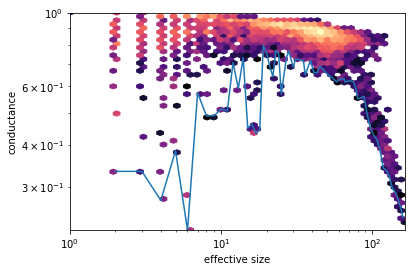

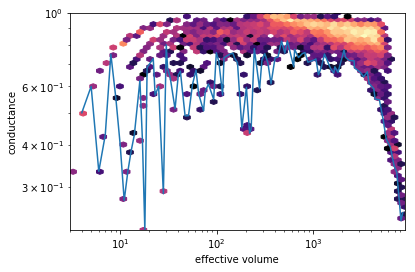

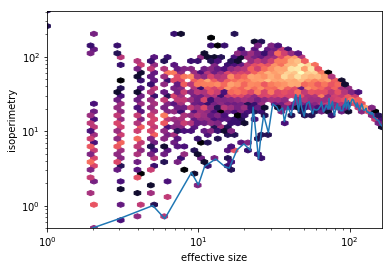

In [15]:
ncp_instance = lgc.NCPData(g)
ncp_instance.approxPageRank(ratio=0.5,timeout=7200)

ncp_plots = lgc.NCPPlots(ncp_instance,method_name = "acl")
#plot conductance vs size
fig, ax = ncp_plots.cond_by_size()
plt.show()
#plot conductance vs volume
fig, ax = ncp_plots.cond_by_vol()
plt.show()
#plot isoperimetry vs size
fig, ax = ncp_plots.isop_by_size()
plt.show()

In [247]:
lgc.fiedler_local(g, feature_ff_nodes_largest_component)

IndexError: index 1 is out of bounds for axis 1 with size 1

In [2]:
# Read John Hopkins graph.
g = lgc.GraphLocal('./datasets/usroads-cc.graphml','graphml')

# Load pre-computed coordinates for nodes.
ld_coord = np.loadtxt('./datasets/usroads-cc.xy', dtype = 'Float64')
ld_coord[:,0] = -ld_coord[:,0]

/usr/local/lib/python3.6/site-packages/localgraphclustering/GraphLocal.py:174: UserWarning: Loading a graphml is not efficient, we suggest using an edgelist format for this API.
  warnings.warn("Loading a graphml is not efficient, we suggest using an edgelist format for this API.")


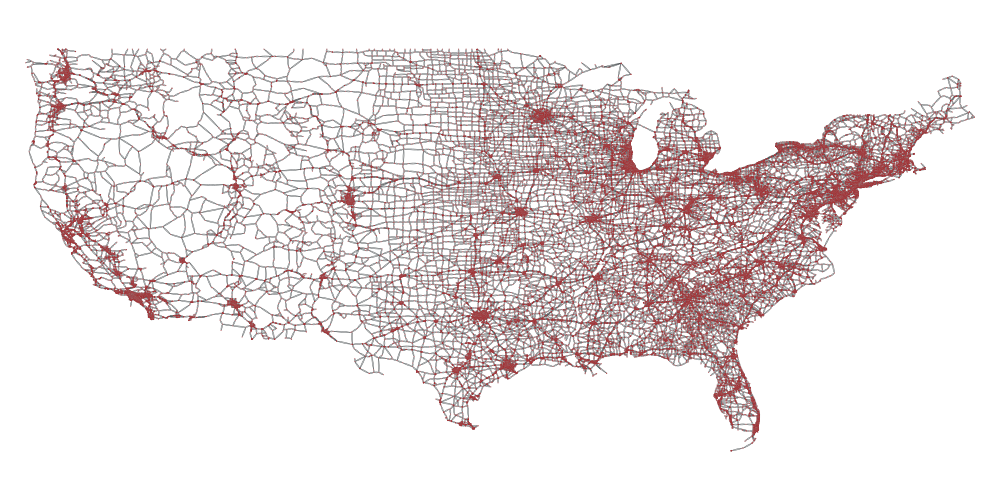

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x13a3310f0, at 0x12b6d1198>

In [3]:
# Add data to graphtool.
g_gtool = load_graph("./datasets/usroads-cc.graphml")
    
remove_self_loops(g_gtool)

pos = g_gtool.new_vertex_property("vector<double>")
for i in range(g._num_vertices):
    pos[i] = -ld_coord[i,:]

c_map = plt.get_cmap('autumn')

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=1,
           edge_pen_width=0.5,
           vcmap=c_map
           #output='./tmp/usroad.png')
          )

In [4]:
ncp_instance = lgc.NCPData(g)
ncp_instance.approxPageRank(ratio=0.5,timeout=7200)

There are  1  connected components in the graph


/usr/local/lib/python3.6/site-packages/localgraphclustering/spectral_clustering.py:92: UserWarning: The weights of the graph will be discarded. Use approximate_PageRank_weighted instead if you want to keep the edge weights.
  warnings.warn("The weights of the graph will be discarded. Use approximate_PageRank_weighted instead if you want to keep the edge weights.")
/usr/local/lib/python3.6/site-packages/localgraphclustering/approximate_PageRank.py:106: UserWarning: The weights of the graph will be discarded. Use approximate_PageRank_weighted instead if you want to keep the edge weights.
  warnings.warn("The weights of the graph will be discarded. Use approximate_PageRank_weighted instead if you want to keep the edge weights.")


<class 'localgraphclustering.ncp.NCPData'>


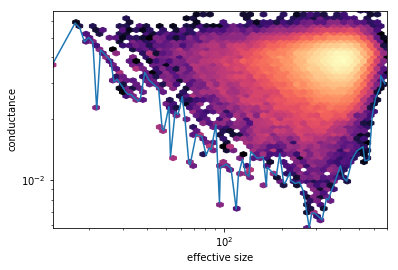

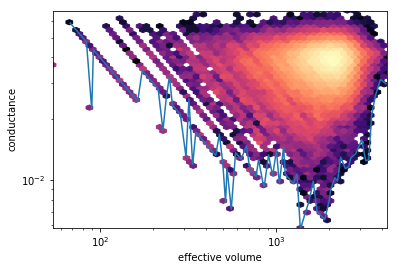

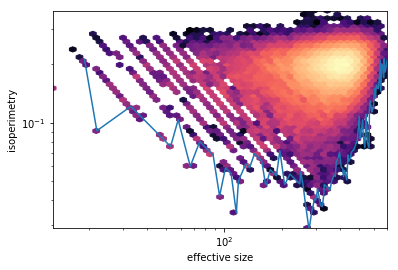

In [5]:
ncp_plots = lgc.NCPPlots(ncp_instance,method_name = "acl")
#plot conductance vs size
fig, ax = ncp_plots.cond_by_size()
plt.show()
#plot conductance vs volume
fig, ax = ncp_plots.cond_by_vol()
plt.show()
#plot isoperimetry vs size
fig, ax = ncp_plots.isop_by_size()
plt.show()

In [17]:
# Read John Hopkins graph.
g = lgc.GraphLocal('./datasets/ca-GrQc-cc.graphml','graphml')

/usr/local/lib/python3.6/site-packages/localgraphclustering/GraphLocal.py:174: UserWarning: Loading a graphml is not efficient, we suggest using an edgelist format for this API.
  warnings.warn("Loading a graphml is not efficient, we suggest using an edgelist format for this API.")


In [18]:
# Add data to graphtool.
g_gtool = load_graph("./datasets/ca-GrQc-cc.graphml")
    
remove_self_loops(g_gtool)

# Compute a layout for the graph.
# pos = sfdp_layout(g_gtool, gamma=10.0, mu=10.0, mu_p=10.0, verbose = False)  

coordinates = pickle.load( open( "ca-GrQc-cc_xy.p", "rb" ) )

pos = g_gtool.new_vertex_property("vector<double>")
for i in range(g._num_vertices):
    pos[i] = coordinates[g_gtool.vertex(i)]

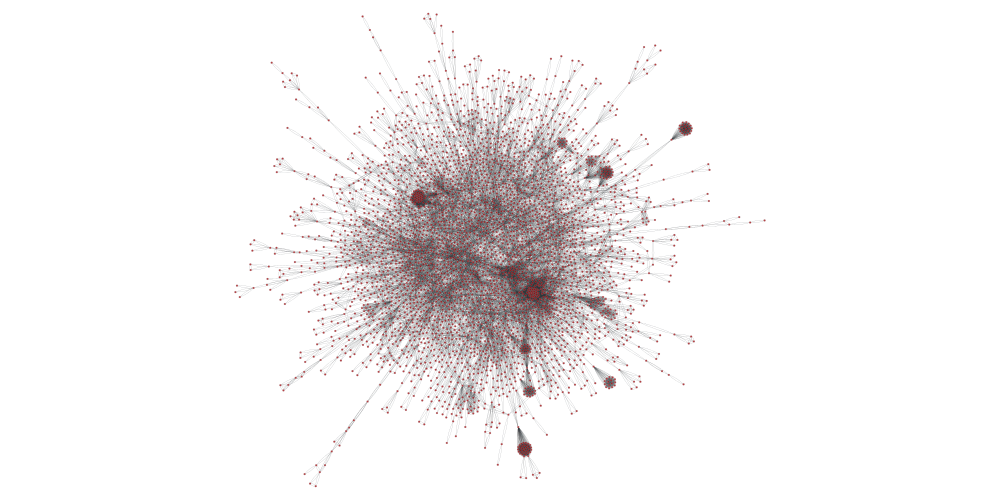

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x135d711d0, at 0x135d71278>

In [19]:
# Plot solutions for global eigenvector

c_map = plt.get_cmap('autumn')

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=2,
           edge_pen_width=0.1,
           vcmap=c_map
           #output='./tmp/ca-GrQc-cc.png')
          )

In [20]:
ncp_instance = lgc.NCPData(g)
ncp_instance.approxPageRank(ratio=0.5,timeout=7200)

There are  1  connected components in the graph


<class 'localgraphclustering.ncp.NCPData'>


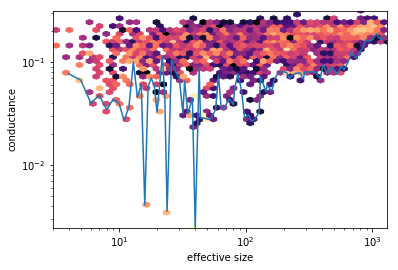

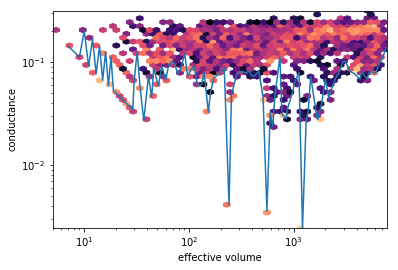

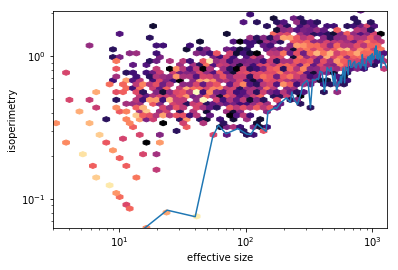

In [21]:
ncp_plots = lgc.NCPPlots(ncp_instance,method_name = "acl")
#plot conductance vs size
fig, ax = ncp_plots.cond_by_size()
plt.show()
#plot conductance vs volume
fig, ax = ncp_plots.cond_by_vol()
plt.show()
#plot isoperimetry vs size
fig, ax = ncp_plots.isop_by_size()
plt.show()